In [0]:
!pip install git+https://github.com/statsmodels/statsmodels.git


  Cloning https://github.com/statsmodels/statsmodels.git to /tmp/pip-req-build-2nqcm5y1
  Running command git clone -q https://github.com/statsmodels/statsmodels.git /tmp/pip-req-build-2nqcm5y1
  Stored in directory: /tmp/pip-ephem-wheel-cache-c445nx7b/wheels/7b/bd/6d/3192a61f34609bda0eea70342907984dba2ad17c3abb502ce7
Successfully built statsmodels
  Found existing installation: statsmodels 0.9.0
    Uninstalling statsmodels-0.9.0:
      Successfully uninstalled statsmodels-0.9.0


In [0]:
!pip install -q spams

     |████████████████████████████████| 1.9MB 5.1MB/s 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import sklearn
import math
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
from sklearn.ensemble import RandomForestRegressor
import spams
from numpy import trapz
import scipy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from copy import copy, deepcopy
###################################
#  LASSO

def Lasso_lambda(x,y,lambda1):
  param = {
    'lambda1' : lambda1, # not more than 20 non-zeros coefficients
    'lambda2' : 0,
    'L': x.shape[1],
    'mode' : 2 }       
  y= np.reshape(y, (y.shape[0], 1))  
  (A,path) = spams.lasso(np.asfortranarray(y),np.asfortranarray(x),return_reg_path = True,**param)
  return path,A 

#################################
def kfold_CV(X,y,cv):
  lambdas=np.arange(0.001,0.01,0.001)
  table=np.zeros((lambdas.shape[0],cv))
  sumscore=np.zeros((lambdas.shape[0],1))
  kf = KFold(n_splits=cv)
  i=0 
  j=0
  for lambda_ in lambdas:
    i=i+1 
    j=0
    for train_index, test_index in kf.split(X):
        j=j+1          
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]  
        (path,A)=Lasso_lambda(X_train,y_train,lambda_)          
        y_pred=PredictCV(X_test,X_train,path)
        table[i-1][j-1]=mean_squared_error(y_test, y_pred)
       
  for i in range(lambdas.shape[0]):
    sumscore[i,0]=np.sum(table[i,:], axis=0)   
  lambda_best=lambdas[np.argmin(sumscore)]
  return lambda_best 
#########################################
def PredictCV(X_test,X_train,path):
  coefs=path[:,X_train.shape[1]]
  Xm=np.copy(X_test)
  for i in range(X_test.shape[1]):
    for j in range(X_test.shape[0]):
      Xm[j,i]=X_test[j,i]*coefs[i]
  y_pred=np.zeros((X_test.shape[0],1))
  for i in range(X_test.shape[0]):
    y_pred[i,0]=np.sum(Xm[i,:], axis=0)
  return y_pred
###################################
#Stability Selection using LASSO

def indexmul(X,f):
  a=X.shape
  XX=np.copy(X)
  for i in range(a[1]):
    XX[:,i] = X[:,i]*f[i]
  return XX

def stability_selection(x,y,R,alpha,cv):
  (n,p)=x.shape
  halfsize=math.floor(n/2)
  freq = np.full((x.shape[1],x.shape[1]+1), 0,dtype=float)
  #lambda_cv=kfold_CV(x,y,cv)
  param = {
    'lambda1' : 0.00001, # not more than 20 non-zeros coefficients
    'lambda2' : 0,
    'L': x.shape[1],
    'mode' : 2 }       
  y= np.reshape(y, (y.shape[0], 1))
  pr={}
  for i in range(0,R):
    xs=indexmul(x,(alpha + (1-alpha)*np.random.uniform(0,1,p)))
    perm=np.random.permutation(n)
    pr[i] = perm[1:halfsize]
    
    (A,path) = spams.lasso(np.asfortranarray(y[( pr[i]),:]),np.asfortranarray(xs[( pr[i]),:]),return_reg_path = True,**param)
    
    freq=freq+abs(np.sign(path[:,0:x.shape[1]+1]))
  Area=np.full((1, x.shape[1]), 0,dtype=float) 
  for i in range(x.shape[1]):
    y = freq[i,1:x.shape[1]+1]/x.shape[1]
    Area[0][i]=(trapz(y, dx=x.shape[1]/100))
  return Area.reshape(-1,1)
######################
# Find t-statistics of linear regression

def get_confidence_OLS_wald(X,y):
  model = sm.OLS(y, X).fit()
  #return abs(model.tvalues.reshape(-1,1))
  return 1-model.pvalues.reshape(-1,1)
###########################
def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return p
##########################
def get_confidence_OLS_lr(predictors,target):

  number=predictors.shape[1]
  pval=np.full((1, number), 0,dtype=float)
  md = sm.OLS(target , predictors  )
  mdf = md.fit()
  llff = mdf.llf
  for i in range(number):
      g=[]
      for k in range(number):
        g.append(k)
      del g[i]
      mdl= sm.OLS(target,  predictors[:,tuple(g)] )
      mdfl= mdl.fit()
      llfl= mdfl.llf
      p = lrtest( llfl, llff)
      pval[0][i]=p 
  return 1-(pval).reshape(-1,1)        
  ############################

def f1score(TrueMatrix,EstMatrix):
  return f1_score(TrueMatrix.flatten(), EstMatrix.flatten() )
###################
def get_confidence_OLS_RF(X,y):
  regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=200 ,max_features="sqrt")
  regr.fit(X, y) 
  return regr.feature_importances_.reshape(-1,1)

##############

def draw_network(r,n_o_edge,labels):
    r1=list(set(r.values[:,0]))
    r2=list(set(r.values[:,1]))
    R=(list(set(r1+r2)))
    networkd=r.values[0:n_o_edge,:]
    DG=nx.DiGraph()
    DG.add_nodes_from(tuple(R))
    for i in range(n_o_edge):
        DG.add_edges_from([(networkd[i][0],networkd[i][1])])
    return nx.draw(DG,labels,with_labels = True,node_size=60,font_size=50)




In [0]:

#################3
def ResultMat(Result,threshold):
    N=len(set(Result["Regulated"].values))
    mapx=np.full((N, N), 0,dtype=float)
    for i in range(Result.shape[0]):
      if Result.iloc[i,2]<threshold:
        a=list(Result["Regulator"])[i] 
        b=list(Result["Regulated"])[i] 
        mapx[a,b]=1
    return mapx
######
def enwindow(w,s,g):
    q=[]
    t=len(g)
    for i in range(0,t-w+1,s):
        q.append(g[i:i+w])
    return q
###########################
def concat_list(X):   # concatenate multiple matrices in a list
  Q=X[0].shape[1]
  Predictors = np.empty((Q, 0))
  for k in range(0,len(X)):
      Predictors = np.append(Predictors, X[k].transpose(), axis = 1)
  return Predictors
########################
def All_Lag_Value(a,b,l,Q,A_m,N):
    Array=np.full((Q-1, 1), 0,dtype=float)
    for i in range(Q-1-l):
      Array[i]=A_m.iloc[b+(i*N),a+(l*N)+((i)*N)]
    return Array
######################



def inference(G,w,k_min,k_max,method):
  T=G.shape[1] # length of time series
  N=G.shape[0]  # number of genes
  s=1 # step size
  
  #L = k_max - k_min + 1 # cardinality of the set
  Q= int((T-w+1)/s  )   # number of windows
  windowed_G=np.zeros([N,Q,w])  #matrix in left-bottom of Fig.1
  for i in range(0,N):
    windowed_G[i,:,:] = enwindow(w,s,G[i,:])
    
  Windows =[]
  for i in range(0,Q):
    Windows.append(windowed_G[:,i,:]) 
    A = np.nan*np.ones([N*Q,N*Q])
  for q in range(0,Q):#Q
    
#------------------------------------------    
# generate matrix of predictors for each delay

    if k_min < q+1 <= k_max:
            X=[]
            for i in np.arange(0,q-k_min+1):
                X.append(Windows[i]) 

    if q+1 > k_max:
        X=[]
        for i in np.arange(q-k_max,q-k_min+1):
                X.append(Windows[i]) 
 #-------------------------------------
# build the regression for each gene          
    Predictors = concat_list(X)
    a = np.zeros([Predictors.shape[1],N])     
  
    for n in range(0,N):#

        Target     = X[-1][n,:]
        
        #if k_min==0:
        #remove target from predictors
        f=Predictors.shape[1]
        mask = np.ones(Predictors.shape[1], dtype=bool)
        mask[(f-N+n)] = False
        Predictors_ = Predictors[:,mask]

        if method=="LR":
            Coefficients_ = get_confidence_OLS_lr(Predictors_, Target)
        if method=="WALD":
            Coefficients_ = get_confidence_OLS_wald(Predictors_, Target)
        if method=="RF":    
            Coefficients_ = get_confidence_OLS_RF(Predictors_, Target)
        if method=="ST":    
            Coefficients_ =stability_selection(Predictors_, Target,5,0.2,5)
            
        m=len(Coefficients_) # add np.nan in the coefficients
        Coefficients = np.vstack((Coefficients_[:m-N+n+1,:], [np.nan], Coefficients_[m-N+n+1:,:]))

        a[:,n] = Coefficients.transpose()
#-------------------------------------
# Create matrix A
    if k_min < q+1 <= k_max:
        A[0 :  (q-k_min+1)*N , q*N  :(q+1)*N] = a
        
    if q+1 > k_max:
        A[(q-k_max)*N :  (q-k_min+1)*N  ,  q*N :  (q+1)*N] = a
        
        
        
  A_m = pd.DataFrame(A)
  Ind=[]
  for n in range(0,Q):
    for q in range(0,N):
        Ind.append (str(q) + "-"+ str(n))  #"g" + "-" + 
  A_m.index = Ind   
  A_m.columns = Ind
  
  Results = []
  for n1 in range(0,N):
    for n2 in range(0,N): 
      for l in range(k_min,k_max):
        if n1!=n2:
            m=All_Lag_Value(n1,n2,l,Q,A_m,N)
            avg  = np.nanmean(m)
            #avg  = np.nanmedian(m)
            Results.append([n2,n1,avg,l])
   
  Results  = pd.DataFrame(Results) 
  Results.columns = ['Regulator','Regulated',"Score","Delay"]

 
  Results=Results[Results["Delay"]!=0]
  #return Results.groupby(['Regulator','Regulated',"Delay"]).agg("min").sort_values("Score").reset_index()

  return Results.sort_values("Score", ascending=False)
  ###################

In [0]:
from google.colab import files
uploaded = files.upload()

Saving tt.csv to tt.csv


In [0]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

User uploaded file "tt.csv" with length 10912 bytes


In [0]:
import pandas as pd
import io
#df = pd.read_excel(io.StringIO(uploaded['Untitled 1.csv']))
df = pd.read_csv(io.StringIO(uploaded['tt.csv'].decode('utf-8')) ,delimiter='\,',encoding='utf-8')
print(df)

    0.264316  0.448647    0.4308  ...  -0.073441  -0.5014595  -0.4856775
0   0.246450  0.499191  0.597364  ...  -0.166870   -0.635970   -0.479532
1  -0.019423  0.352952  0.636145  ...  -0.165781   -0.671740   -0.533276
2  -0.092572  0.080114  0.665840  ...  -0.031162   -0.443155   -0.386262
3  -0.189855  0.203187  0.216126  ...  -0.045983   -0.442218   -0.391690
4  -0.467700 -0.225586  0.150169  ...   0.369658    0.108114   -0.302014
5  -0.331496 -0.386873 -0.083792  ...   0.683190    0.308391   -0.050450
6  -0.649647 -0.757563 -0.489485  ...   0.938604    0.562019    0.247448
7  -0.627474 -0.846596 -0.640548  ...   1.044721    0.777904    0.356952
8  -0.362726 -1.185242 -0.703117  ...   0.980873    0.960226    0.449353
9  -0.532644 -0.762269 -0.516052  ...   0.151880    0.806687    0.318690
10 -0.139676 -0.590025 -0.251057  ...  -0.346693    0.638962    0.354239
11  0.018920 -0.432622 -0.301935  ...  -0.752375    0.250868    0.196787
12  0.496766 -0.021554  0.068147  ...  -0.925987   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [0]:
df.values[:,(0,1,2,3,4,8,11,13,19)].shape

(47, 9)

In [0]:
G=df.values[:,(0,1,2,3,4,8,11,14,19)].transpose()

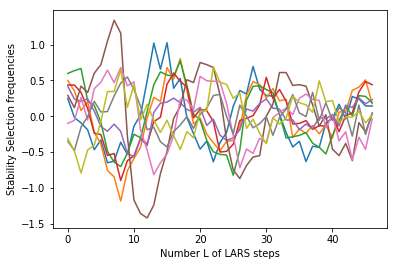

In [0]:
import matplotlib.pyplot as plt

 
plt.plot(G[0,:]) # plotting by columns
plt.plot(G[1,:]) # plotting by columns
plt.plot(G[2,:]) # plotting by columns
plt.plot(G[3,:]) # plotting by columns
plt.plot(G[4,:]) # plotting by columns
plt.plot(G[5,:]) # plotting by columnsplt.plot(G[0,:]) # plotting by columns
plt.plot(G[6,:]) # plotting by columns
plt.plot(G[7,:]) # plotting by columns
plt.plot(G[8,:]) # plotting by columns
 
plt.xlabel('Number L of LARS steps')
plt.ylabel('Stability Selection frequencies')

plt.show()

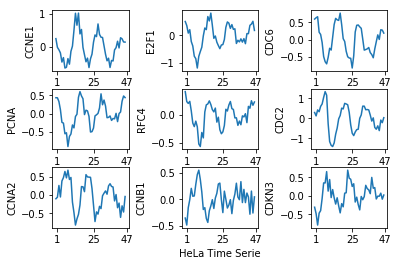

In [0]:
plt.subplots_adjust(wspace=0.7, hspace=0.3)
plt.subplot(3, 3, 1)
plt.plot(G[0,:]) # plotting by columns
plt.ylabel("CCNE1")
plt.xticks([1,25,47])

         
plt.subplot(3, 3, 2)
plt.plot(G[1,:]) # plotting by columns
plt.ylabel("E2F1")
plt.xticks([1,25,47])


plt.subplot(3, 3, 3)
plt.plot(G[2,:]) # plotting by columns
plt.ylabel("CDC6")
plt.xticks([1,25,47])


plt.subplot(3, 3, 4)
plt.plot(G[3,:]) # plotting by columns
plt.ylabel("PCNA")
plt.xticks([1,25,47])


plt.subplot(3, 3, 5)
plt.plot(G[4,:]) # plotting by columns
plt.ylabel("RFC4")
plt.xticks([1,25,47])


plt.subplot(3, 3, 6)
plt.plot(G[5,:]) 
plt.ylabel("CDC2")
plt.xticks([1,25,47])


plt.subplot(3, 3, 7)
plt.plot(G[6,:]) # plotting by columns
plt.ylabel("CCNA2")
plt.xticks([1,25,47])


plt.subplot(3, 3, 8)
plt.plot(G[7,:]) # plotting by columns
plt.ylabel("CCNB1")
plt.xticks([1,25,47])


plt.xlabel('HeLa Time Serie')

plt.subplot(3, 3, 9)

plt.plot(G[8,:]) # plotting by columns
plt.ylabel("CDKN3")
plt.xticks([1,25,47])


plt.show()

In [0]:
G.shape

(9, 47)

In [0]:
T=47


In [0]:
w=int(np.floor(3*T/4)) # window length
k_min = 0
k_max = 3

In [0]:
G.shape[1]

47

In [0]:
st=inference(G,w,k_min,k_max,"ST").round(3)

In [0]:
st=st.reset_index()
del st["index"]
st = st.rename(columns={'Score': 'st_score'})
st["st_rank"]=range(0,st.shape[0])
st.head()

,Regulator,Regulated,st_score,Delay,st_rank
0,5,6,0.829,1,0
1,5,7,0.710,2,1
2,5,0,0.640,2,2
3,5,6,0.615,2,3
4,6,1,0.580,2,4


In [0]:
lr=inference(G,w,k_min,k_max,"LR").round(3)


In [0]:
lr=lr.reset_index()
del lr["index"]
lr = lr.rename(columns={'Score': 'lr_score'})
lr["lr_rank"]=range(0,lr.shape[0])
lr.head()

,Regulator,Regulated,lr_score,Delay,lr_rank
0,2,7,0.917,1,0
1,2,0,0.916,1,1
2,7,0,0.916,1,2
3,0,7,0.912,1,3
4,6,2,0.912,1,4


In [0]:
wald=inference(G,w,k_min,k_max,"WALD").round(3)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [0]:
wald=wald.reset_index()
del wald["index"]
wald = wald.rename(columns={'Score': 'wald_score'})
wald["wald_rank"]=range(0,wald.shape[0])
wald.head()

,Regulator,Regulated,wald_score,Delay,wald_rank
0,2,7,0.649,1,0
1,2,0,0.601,1,1
2,6,2,0.594,1,2
3,7,0,0.593,1,3
4,5,3,0.586,1,4


In [0]:
rf=inference(G,w,k_min,k_max,"RF").round(3)

In [0]:
rf=rf.reset_index()
del rf["index"]
rf = rf.rename(columns={'Score': 'rf_score'})
rf["rf_rank"]=range(0,rf.shape[0])
rf.head()

,Regulator,Regulated,rf_score,Delay,rf_rank
0,5,6,0.145,1,0
1,1,4,0.112,1,1
2,5,0,0.110,2,2
3,6,0,0.109,1,3
4,6,1,0.099,2,4


In [0]:
st.values[:,2].mean()

0.32123611111111106

In [0]:
st

,Regulator,Regulated,st_score,Delay,st_rank
0,5,6,0.829,1,0
1,5,7,0.710,2,1
2,5,0,0.640,2,2
3,5,6,0.615,2,3
4,6,1,0.580,2,4
5,0,8,0.579,2,5
6,5,1,0.574,2,6
7,8,5,0.570,2,7
8,3,1,0.561,2,8
9,1,3,0.559,1,9


In [0]:
tr=lr.values[:,2].mean()

In [0]:
lr[lr.values[:,2]<tr]

,Regulator,Regulated,lr_score,Delay,lr_rank
54,5,2,0.835,1,54
55,3,1,0.833,2,55
56,5,2,0.833,2,56
57,5,6,0.833,2,57
58,5,1,0.833,2,58
59,5,3,0.833,2,59
60,3,2,0.833,2,60
61,3,6,0.833,2,61
62,3,5,0.833,2,62
63,2,0,0.833,2,63


In [0]:
lr

,Regulator,Regulated,lr_score,Delay,lr_rank
0,2,7,0.917,1,0
1,2,0,0.916,1,1
2,7,0,0.916,1,2
3,0,7,0.912,1,3
4,6,2,0.912,1,4
5,6,5,0.911,1,5
6,8,6,0.910,1,6
7,2,4,0.910,1,7
8,8,7,0.910,1,8
9,5,3,0.909,1,9


In [0]:
wald

,Regulator,Regulated,wald_score,Delay,wald_rank
0,2,7,0.649,1,0
1,2,0,0.601,1,1
2,6,2,0.594,1,2
3,7,0,0.593,1,3
4,5,3,0.586,1,4
5,6,5,0.549,1,5
6,5,1,0.544,1,6
7,6,3,0.542,1,7
8,0,7,0.538,1,8
9,8,6,0.533,1,9


In [0]:
rf

,Regulator,Regulated,rf_score,Delay,rf_rank
0,5,6,0.145,1,0
1,1,4,0.112,1,1
2,5,0,0.110,2,2
3,6,0,0.109,1,3
4,6,1,0.099,2,4
5,5,0,0.096,1,5
6,1,3,0.095,1,6
7,0,2,0.091,1,7
8,0,1,0.089,1,8
9,5,6,0.088,2,9


In [0]:
rf.shape,lr.shape,wald.shape,st.shape

((144, 5), (144, 5), (144, 5), (144, 5))

In [0]:
#st,lr,wald,rf
A=pd.merge(st,lr,on=['Regulator','Regulated',"Delay"])
A=pd.merge(A,wald,on=['Regulator','Regulated',"Delay"])
A=pd.merge(A,rf,on=['Regulator','Regulated',"Delay"])
A["Average_rank"]=(A["st_rank"]+A["lr_rank"]+A["wald_rank"]+A["rf_rank"])/4
A=A.sort_values("Average_rank")

A=A[["Regulator","Regulated","Average_rank","Delay"]]

In [0]:
A

,Regulator,Regulated,Average_rank,Delay
15,6,2,15.00,1
27,2,7,15.50,1
0,5,6,15.50,1
64,0,7,23.25,1
16,2,8,23.75,1
24,5,1,25.50,1
3,5,6,26.00,2
34,0,8,27.00,1
28,6,1,27.25,1
9,1,3,27.50,1


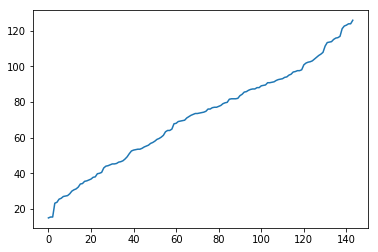

In [0]:
plt.plot(A.Average_rank.values)

In [0]:
TrueMatrix=np.zeros((9,9))

In [0]:
TrueMatrix[0,(1,2,5)]=1
TrueMatrix[1,6]=1
TrueMatrix[2,6]=1
TrueMatrix[3,(0,2,4,6,7)]=1
TrueMatrix[5,(1,2,6,7,8)]=1
TrueMatrix[6,(1,2,3,5)]=1
TrueMatrix[7,(3,2,5)]=1
TrueMatrix[8,5]=1

In [0]:
TrueMatrix

array([[0., 1., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 1., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 1., 1., 1.],
       [0., 1., 1., 1., 0., 1., 0., 0., 0.],
       [0., 0., 1., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [0]:
def r_to_f1(r,TrueMatrix):
  r1=list(set(r.values[:,0]))
  r2=list(set(r.values[:,1]))
  R=(list(set(r1+r2)))
  tr=r.values[:,2].mean()
  networkd=r[r.values[:,2]<tr].values
  EstMatrix=np.zeros((TrueMatrix.shape[0],TrueMatrix.shape[1]))
  for i in range( networkd.shape[0]):
    EstMatrix[int(networkd[i,0]),int(networkd[i,1])]=1
  f1=f1score(np.abs(TrueMatrix),EstMatrix)
  return f1

In [0]:
r_to_f1(st,TrueMatrix)

0.3835616438356165

In [0]:
r_to_f1(lr,TrueMatrix)

0.4842105263157894

In [0]:
r_to_f1(wald,TrueMatrix)

0.47058823529411764

In [0]:
r_to_f1(rf,TrueMatrix)

0.4050632911392405

In [0]:
def r_to_f1(r,TrueMatrix,tr):
  r1=list(set(r.values[:,0]))
  r2=list(set(r.values[:,1]))
  R=(list(set(r1+r2)))
  
  networkd=r[r.values[:,4]<tr].values
  EstMatrix=np.zeros((TrueMatrix.shape[0],TrueMatrix.shape[1]))
  for i in range( networkd.shape[0]):
    EstMatrix[int(networkd[i,0]),int(networkd[i,1])]=1
  f1=f1score(np.abs(TrueMatrix),EstMatrix)
  return f1

In [0]:
B=[]
for i in range(0,201):
  B.append(  r_to_f1(st,TrueMatrix,tr=i))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
max(B)

0.575

In [0]:
np.argmax(B)

88

In [0]:
B=[]
for i in range(0,201):
  B.append(  r_to_f1(lr,TrueMatrix,tr=i))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
max(B)

0.4893617021276596

In [0]:
np.argmax(B)

113

In [0]:
B=[]
for i in range(0,201):
  B.append(  r_to_f1(wald,TrueMatrix,tr=i))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
max(B)

0.4893617021276596

In [0]:
np.argmax(B)

111

In [0]:
B=[]
for i in range(0,201):
  B.append(  r_to_f1(rf,TrueMatrix,tr=i))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
max(B)

0.4893617021276596

In [0]:
np.argmax(B)

132

In [0]:

CGC=np.zeros((10,10))

NameError: ignored

In [0]:
CGC[0,0]=1
CGC[3,3]=1
CGC[5,(7,9)]=1
CGC[6,(3,8)]=1
CGC[7,(4,9)]=1
CGC[8,(5,8)]=1
CGC[9,(1,6)]=1




NameError: ignored